# The Neuron (Logistic Regression)

A single neuron with a sigmoid activation function performs the exact same calculations as logistic regression.
A line (or hyperplane) of best fit is found such that it linearly separates the target classes.
An assumption is made that the classes are linearly seperable and as a consequence if they are not, the algorithm will perform poorly.


## Optimization Objective

A neuron makes predictions based on the formula of a line (Madden, 2021).
In neural network termonology the goal is to find a set of weights and a bias term that minimizes the loss function.
The result of minimizing the loss function is that a line (or hyperplane) linearly separates the classes.


## Gradient Descent

Gradient Descent is a general-purpose algorithm that can be used to find variables that minimize an objective function (as long as that function adheres to certain properties, e.g. its differentiable) (Madden, 2021).
Gradient descent operates by taking incremental steps 'downhill' in the right direction until convergence is reached.
Note: the logistic regression function is concave and as such there is an overall minimum which can be found.
To update a particular weight the partial derivative (slope) with respect to J specifies which direction (+/-) to move in and the learning_rate hyperparameter dictates by how much the weight should be moved.

### Stochastic Gradient Descent

With stochastic gradient descent a single step is based on only one example.
This means the derivative of J is based on a single training data point at a time.


## Implementation Details

The algorithm was implemented as a scikit-learn classifier estimator (scikit-learn, 2022).
In doing so the implementations becomes compatible with all of the tools provided by the framework.
As such, the algorithm is implemented from scratch where as everything else is provided by scikit-learn.
This includes evaluation metrics calculations, learning curve plots and hyperparameter tuning.
An effort was made to name the hyperparameters to the same names as the MLPClassifier (scikit-learn, 2022) to make them easier to understand.
To make the algorithm more efficient the operations were vectorized taking advantage of the numpy library.
The implementation offers three hyperparameters:
1. learning_rate - how much to update the weights at each iteration
2. tol - if the loss changes by less than this amount it is considered that the algorithm has converged.
3. max_iter - if the algorithm has reached this many iterations and not converged it will stop.

### Validation

The implementation was validated by plotting a loss curve (loss per iteration).
If the model is learning the expectation is that the loss should decrease as iteratons increase which is observed to be true.

## Evaluation

In order to validate correctness a loss curve and a learning curve were plotted.
The implementation was evaluated based on the circles and blobs datasets provided.
The dataset was split as follows:
* Training set: 70%
* Validation set: 15%
* Test set: 15%

A hyperparameter search based on the F1 metric was carried out on both datasets, yielding the best hyperparemeters to be: 
* Blobs dataset: {'learning_rate': 0.1, 'max_iter': 200, 'tol': 0.001}
* Circles dataset: {'learning_rate': 0.1, 'max_iter': 500, 'tol': 1e-05}

With the above hyperparameters the algorithm achieved:
* Blobs dataset: an F1 score of 1.0 and accuracy of 1.0.
* Circles dataset: an F1 score of 0.7499999999999999 and accuracy of 0.6444444444444445.

### Observations
* As the blobs dataset is linearly seperable it resulted in a perfect score.
  * However, this could also just be a 'lucky' test set split.
* As the circles dataset is not linearly seperable the model does not perform well.
  This is expected as the algorithm makes an assumption that the dataset is linearly seperable.

In [1]:
# NOTE: Notebook was run with Python 3.9
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import classification_report
from sklearn.utils import check_X_y, check_array
from numpy import log
import pandas as pd
import numpy as np
import random
import sys
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.model_selection import train_test_split
from sklearn.model_selection import ParameterGrid
from sklearn.utils.validation import check_is_fitted
from sklearn.metrics import classification_report
from sklearn.utils import check_X_y, check_array
from sklearn.metrics import f1_score, accuracy_score
from itertools import product
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random
import math
import sys
import numpy as np
import pickle
import glob
import warnings
import os
from sklearn.preprocessing import StandardScaler, Normalizer

import warnings
warnings.filterwarnings(action='once')


# Set seeds to make notebook reproducable
seed = 72
random.seed(seed)
np.random.seed(seed)

In [2]:
def sigmoid(z):
    return 1 / (1 + math.exp(-z))

class Neuron(ClassifierMixin, BaseEstimator):
    def __init__(self, learning_rate=0.01, tol=1e-4, max_iter=500, loss_callback=None):
        self.loss_callback = loss_callback
        self.logistic = sigmoid
        self.learning_rate = learning_rate
        self.tol = tol
        self.max_iter = max_iter

    def predict_proba(self, X):
        X = check_array(X)
        check_is_fitted(self, ('w_', 'b_'))
        return np.array([self.logistic(self.w_ @ x + self.b_) for x in X])

    def predict(self, X):
        y = self.predict_proba(X)
        return np.array([0 if prob < 0.5 else 1 for prob in y])

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self._num_samples, self._num_features = X.shape
        self.w_, self.b_ = self._descend(X, y)
        return self

    def _descend(self, X, ys):
        # Initialisation
        num_samples, num_features = X.shape
        J_prev = sys.maxsize
        w = np.random.uniform(0, 1, (1, self._num_features))
        b = random.uniform(0, 1)

        for i in range(self.max_iter):
            # Forward propagation
            inx = random.randrange(num_samples)
            x, y = X[inx], ys[inx]  # randomly select an example

            # Compare J_curr with J_prev: break from loop if convergence is reached
            y_hat = self.logistic(w @ x + b)  # calculate y_hat from x, w, b
            J_curr = -((y * log(y_hat)) + ((1 - y) * log(1 - y_hat)))  # calculate J_curr from y, y_hat
            if self.loss_callback is not None:
                self.loss_callback(i, J_curr)
            if abs(J_prev - J_curr) <= self.tol:
                break
            J_prev = J_curr

            # Gradient Descent
            # 1) Calculate partial derivatives
            d_w = (y_hat - y) * x
            d_b = y_hat - y

            # 2) Update weights based on partial derivatives
            w -= self.learning_rate * d_w
            b -= self.learning_rate * d_b

        return w, b

In [3]:
def load(path):
    df = pd.read_csv(path)

    # The y values are those labelled 'Class': extract their values
    y = df['Class'].values

    # The x values are all other columns
    del df['Class'] # drop the 'Class' column from the dataframe
    
    X = df.values # convert the remaining columns to a numpy array
    return X, y

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import learning_curve
from sklearn import datasets
import matplotlib.pyplot as plt

def plot_loss_curve(model, X, y, hyperparams={}, xlabel="Iterations"):
    losses = []
    def loss_callback(i, J):
        losses.append(J)
    model = model(loss_callback=loss_callback, **hyperparams)
    model.fit(X, y)
    plt.plot(list(range(len(losses))), losses)
    plt.title('Loss Curve')
    plt.xlabel(xlabel)
    plt.ylabel('Loss (J)')
    plt.show()

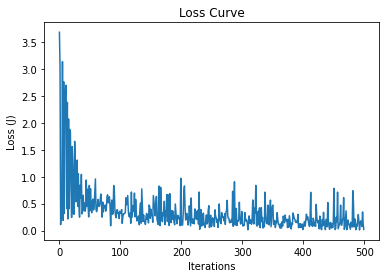

In [5]:
plot_loss_curve(Neuron, *load('data/blobs300.csv'))

In [6]:
def split(X, y):
    # Split into train (70%), test (15%), validation (15%)
    X_train, X_rest, y_train, y_rest = train_test_split(X, y, test_size=0.3, random_state=seed)
    X_test, X_val, y_test, y_val = train_test_split(X_rest, y_rest, test_size=0.5, random_state=seed)
    
    return X_train, X_test, X_val, y_train, y_test, y_val

def evaluate(model, hyperparams, X_train, X_test, X_val, y_train, y_test, y_val):
    scores = []
    for params in ParameterGrid(hyperparams):
        estimator = model(**params)
        estimator.fit(X_train, y_train)
        preds = estimator.predict(X_val)
        scores.append((params, f1_score(preds, y_val), accuracy_score(preds, y_val), preds, estimator))

    scores.sort(key=lambda x: x[2], reverse=True)
    bestparams, f1, accuracy, preds, estimator = scores[0]
    print("Hyperparameters with optimal F1 score of {} (with accuracy of {}) on the validation set are:\n{}".format(f1, accuracy, bestparams))
    preds = estimator.predict(X_test)
    print("Test set F1 score of {} and accuracy of {}".format(f1_score(y_test, preds), accuracy_score(y_test, preds)))
    print("Test set classification report:\n{}\n".format(classification_report(y_test, estimator.predict(X_test))))
    return model

blobs300 = split(*load('data/blobs300.csv'))
circles600 = split(*load('data/circles600.csv'))

In [7]:
hyperparams = {
    "learning_rate": [0.1, 0.01, 0.001],
    "tol": [1e-3, 1e-4, 1e-5],
    "max_iter": [200, 500, 1000]
}
print("Blobs dataset evaluation:")
best = evaluate(Neuron, hyperparams, *blobs300)
print()
print()

print("Circles dataset evaluation:")
evaluate(Neuron, hyperparams, *circles600)

Blobs dataset evaluation:
Hyperparameters with optimal F1 score of 0.9767441860465117 (with accuracy of 0.9777777777777777) on the validation set are:
{'learning_rate': 0.1, 'max_iter': 200, 'tol': 0.001}
Test set F1 score of 1.0 and accuracy of 1.0
Test set classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        19
           1       1.00      1.00      1.00        26

    accuracy                           1.00        45
   macro avg       1.00      1.00      1.00        45
weighted avg       1.00      1.00      1.00        45




Circles dataset evaluation:
Hyperparameters with optimal F1 score of 0.7394957983193278 (with accuracy of 0.6555555555555556) on the validation set are:
{'learning_rate': 0.1, 'max_iter': 500, 'tol': 1e-05}
Test set F1 score of 0.7499999999999999 and accuracy of 0.6444444444444445
Test set classification report:
              precision    recall  f1-score   support

           0       

__main__.Neuron

# Shallow Neural Network

A shallow neural network consists of a set of nodes organised in a single hidden layer that is then fed into a final output node to calculate the prediction.
Each node in the hidden layer performs the same calculation as the neuron in the previous example with one difference; the activation function may be different.
One intuition as to why this works well is that it can be viewed as an ensemble of logistic regression nodes, the output node uses the predictions of the classifiers in the hidden layer to make the best prediction possible (Madden, 2021).

## Optimization Objective

The optimization objective in this case is to find the best weights and biases for every single neuron such that the loss is minimized.

## Gradient Descent

Once again the optimization objective is obtained through the gradient descent algorithm.
In this case the implementation is known as **back propogation** (Madden, 2021).
This involvs a forward pass where the activations of the hidden layer are cached, followed by a backward pass which makes use of the cached values to calculate the derivatives more efficiently.

### Stochastic Gradient Descent

Again, stochastic gradient descent is used (descend based on one example at a time).


## Implementation Details

Once again and for the same reasons the implementation follows the scikit-learn API as in the previous example.
The operations where vectorized to make the algorithm more efficient.
The implementation offers the same hyperparameters as the neuron and introduces two additional:
1. hidden_layer_size - how many nodes in the hidden layer
2. activation - the activation function to use for the hidden layer node options are: sigmoid, relu, leakyrelu and tanh.

### Validation

The implementation was verified using a loss curve which exhibited the expected behaviour of a descreasing loss as number of iterations increase.

## Evaluation
The evaluation dataset splits are identical to the Neuron splits.

A hyperparameter search based on the F1 metric was carried out on both datasets, yielding the best hyperparemeters to be: 
* Blobs dataset: {'activation': 'relu', 'hidden_layer_size': 3, 'learning_rate': 0.1, 'max_iter': 500, 'tol': 0.001}
* Circles dataset: {'activation': 'relu', 'hidden_layer_size': 4, 'learning_rate': 0.1, 'max_iter': 1000, 'tol': 1e-05}

With the above hyperparameters the algorithm achieved:
* Blobs dataset: an F1 score of 0.962962962962963 and accuracy of 0.9555555555555556.
* Circles dataset: an F1 score of 1.0 and accuracy of 1.0.

### Observations
* Since the logistic regression results were perfect, the likely reason is that the shallow neural network overfit the data.
* Since the shallow neural network can approximate more complex functions it got a perfect score on the circles dataset.
    * However, it is also quite likely that the test split is 'lucky'.

In [8]:
# Activation Functions
class Sigmoid():
    def apply(self, z):
        return 1 / (1 + np.exp(-z))

    def derivative(self, z):
        return self.apply(z) * (1 - self.apply(z))

class Tanh():
    def apply(self, z):
        return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

    def derivative(self, z):
        return 1 - np.exp2(self.apply(z))


class Relu():
    def apply(self, z):
        return np.maximum(z, 0)

    def derivative(self, z):
        return np.where(z <= 0, 0, 1)


class LeakyRelu():
    def apply(self, z):
        return np.where(z > 0, z, z * 0.01)

    def derivative(self, z):
        return np.where(z < 0, 0.01, 1)
    
activations = {
    'sigmoid': Sigmoid,
    'relu': Relu,
    'tanh': Tanh,
    'leakyrelu': LeakyRelu
}

In [9]:
class ShallowNetwork(ClassifierMixin, BaseEstimator):
    def __init__(self, learning_rate=0.01, tol=1e-4, max_iter=500, hidden_layer_size=4, activation='relu', loss_callback=None):
        self.loss_callback = loss_callback
        self.logistic = Sigmoid()
        self.activation = activations[activation]() if type(activation) == str else activation
        self.hidden_layer_size = hidden_layer_size
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol

    def predict_proba(self, X):
        X = check_array(X)
        check_is_fitted(self, ('W_', 'b_'))
        return np.array([self._forward(self.W_, self.b_, x.reshape(self._num_features, 1))[1][-1] for x in X])

    def predict(self, X):
        y = self.predict_proba(X)
        return np.array([0 if prob < 0.5 else 1 for prob in y])

    def fit(self, X, y):
        X, y = check_X_y(X, y)
        self._num_samples, self._num_features = X.shape
        self.W_, self.b_ = self._descend(X, y)
        return self

    def _forward(self, W, bs, x):
        Z = [W[0] @ x + bs[0]]
        A = [self.activation.apply(Z[0])]
        Z.append(W[1] @ A[0] + bs[1])
        A.append(self.logistic.apply(Z[1]))

        return Z, A

    def _backward(self, W, x, y, z, a):
        dz = a[-1] - y
        dW = [None, dz @ a[-2].T]
        db = [None, dz]
        dz = self.activation.derivative(z[0]) @ np.sum(dz * W[1], keepdims=True)
        dW[0] = dz @ x.T
        db[0] = dz

        return dW, db

    def _descend(self, X, ys):
        J_prev = sys.maxsize
        W = [
            # (rows, cols) = (neurons in current layer, neurons in previous layer / features in input)
            np.random.uniform(0, 1, (self.hidden_layer_size, self._num_features)),  # hidden layer
            np.random.uniform(0, 1, (1, self.hidden_layer_size))  # output layer
        ]
        bs = [
            # (rows, cols) = (neurons in current layer, 1)
            np.random.uniform(0, 1, (self.hidden_layer_size, 1)),  # hidden layer
            np.random.uniform(0, 1, (1, 1)),  # output layer
        ]

        for i in range(self.max_iter):
            inx = random.randrange(self._num_samples)
            x, y = X[inx], ys[inx]  # randomly select an example
            x = x.reshape(self._num_features, 1)  # example should be a single column, not a row

            # Forward propagation
            z, a = self._forward(W, bs, x)

            # Compare J_curr with J_prev: break from loop if convergence is reached
            J_curr = -((y * log(a[-1])) + ((1 - y) * log(1 - a[-1])))  # calculate J_curr from y, y_hat
            if self.loss_callback is not None:
                self.loss_callback(i, J_curr[0][0])
            if abs(J_prev - J_curr) <= self.tol:
                break
            J_prev = J_curr

            # Backward propagation to calculate derivatives
            dW, db = self._backward(W, x, y, z, a)

            # Gradient descent
            W = [W[l] - self.learning_rate * dW[l] for l in range(len(W))]
            bs = [bs[l] - self.learning_rate * db[l] for l in range(len(bs))]

        return W, bs

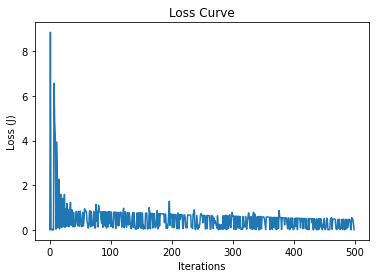

In [10]:
plot_loss_curve(ShallowNetwork, *load('data/blobs300.csv'))

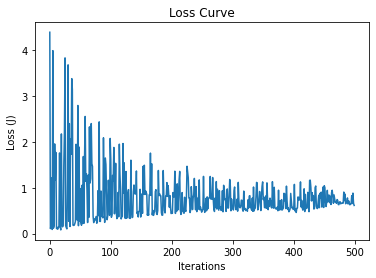

In [11]:
plot_loss_curve(ShallowNetwork, *load('../data/circles600.csv'))

In [12]:
hyperparams = {
    "learning_rate": [0.1, 0.01, 0.001],
    "tol": [1e-3, 1e-4, 1e-5],
    "max_iter": [200, 500, 1000],
    "activation": ["relu", "leakyrelu", "sigmoid", "tanh"],
    "hidden_layer_size": list(range(2, 8))
}
print("Blobs dataset evaluation:")
evaluate(ShallowNetwork, hyperparams, *blobs300)
print()
print()

print("Circles dataset evaluation:")
evaluate(ShallowNetwork, hyperparams, *circles600)

Blobs dataset evaluation:
Hyperparameters with optimal F1 score of 1.0 (with accuracy of 1.0) on the validation set are:
{'activation': 'relu', 'hidden_layer_size': 3, 'learning_rate': 0.1, 'max_iter': 500, 'tol': 0.001}
Test set F1 score of 0.962962962962963 and accuracy of 0.9555555555555556
Test set classification report:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94        19
           1       0.93      1.00      0.96        26

    accuracy                           0.96        45
   macro avg       0.96      0.95      0.95        45
weighted avg       0.96      0.96      0.96        45




Circles dataset evaluation:
Hyperparameters with optimal F1 score of 1.0 (with accuracy of 1.0) on the validation set are:
{'activation': 'relu', 'hidden_layer_size': 4, 'learning_rate': 0.1, 'max_iter': 1000, 'tol': 1e-05}
Test set F1 score of 1.0 and accuracy of 1.0
Test set classification report:
              precision    recall  f1-scor

__main__.ShallowNetwork

# CIFAR-10

The blobs and circles datasets are toy datasets and not considered very challenging.
A more real world dataset that is much more challenging is the CIFAR-10 dataset (Krizhevsky et al, 2009).
"The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class", however in this case the dataset will be reduced to only 2 classes (bird & automobile) making it a binary classification problem.
The dataset was preprocessed to create features by:
1. Creating one large vector of size 3072 (32 width * 32 height * 3 channels).
2. Normalising the vector values using the L2 norm (scikit-learn, 2021).

## Neuron
A hyperparameter search based on the F1 metric was carried out, yielding the best hyperparemeters to be: {'learning_rate': 0.01, 'max_iter': 5000, 'tol': 0.0001}.
With the above hyperparameters the Neuron achieved an F1 score of 0.6666666666666666 and accuracy of 0.5 on the test set.

### Observations

Since this problem is certainly not linearly separable the Neuron did not have a good chance of doing well. As expected, the results are poor, the algorithm labelled each example as an automobile.


## Shallow Neural Network

A hyperparameter search based on the F1 metric was carried out, yielding the best hyperparemeters to be: {'activation': 'relu', 'hidden_layer_size': 768, 'learning_rate': 0.0001, 'max_iter': 10000, 'tol': 1e-05}.
With the above hyperparameters the Neuron achieved an F1 score of 0.6666666666666666 and accuracy of 0.5 on the test set.

### Observations

The problem is quite difficult even for a network with a single hidden layer as the problem is very complex. Exactly like the Neuron, the algorithm labelled each example as an automobile.

In [13]:
!wget https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz

--2022-02-27 21:35:28--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M   280KB/s    in 3m 13s  

2022-02-27 21:38:41 (864 KB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [14]:
!tar xzf cifar-10-python.tar.gz

(10000, 3072)
Label: automobile


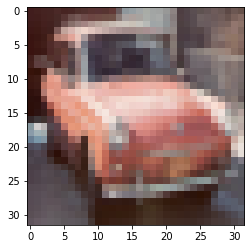

In [15]:
class CIFAR:
    def __init__(self, path):
        self.path = path
        self.labels = self.loadlabelnames()

    def unpickle(self, file):
        with open(file, 'rb') as fo:
            return pickle.load(fo, encoding='bytes')

    def loadbatch(self, batchname):
        return self.unpickle(self.path + "/" + batchname)

    def loadlabelnames(self):
        meta = self.unpickle(self.path + "/" + 'batches.meta')
        return {v.decode('ascii'): i for i, v in enumerate(meta[b'label_names'])}

    def visualise(self, data, index):
        picture = data[index]
        picture.shape = (3, 32, 32)
        picture = picture.transpose([1, 2, 0])
        plt.imshow(picture)
        plt.show()

    def _load(self, glob_search, classes=None):
        X = None
        y = None
        for name in glob_search:
            batch = self.loadbatch(os.path.basename(name))
            if X is None and y is None:
                X = batch[b'data']
                y = np.array(batch[b'labels'])
            else:
                batch_X = batch[b'data']
                batch_y = np.array(batch[b'labels'])
                X = np.concatenate((X, batch_X))
                y = np.concatenate((y, batch_y))

        if classes is not None:
            mask = np.isin(y, [self.labels[c] for c in classes])
            X = X[mask, :]
            y = y[mask]
            for i, c in enumerate(classes):
                y = np.where(y == self.labels[c], i, y)

        return X, y
    
    def training(self, classes=None):
        return self._load(glob.glob('cifar-10-batches-py/data_batch_*'), classes)
    
    def test(self, classes=None):
        return self._load(glob.glob('cifar-10-batches-py/test_batch'), classes)

classes = ['bird', 'automobile']
loader = CIFAR('./cifar-10-batches-py')
X, y = loader.training(classes)
print(X.shape)
inx = 20
print('Label: {}'.format(classes[y[inx]]))
loader.visualise(X, inx)
n = Normalizer()
X = n.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=seed)
X_test, y_test = loader.test(classes)
X_test = n.transform(X_test)
cifar10 = (X_train, X_test, X_val, y_train, y_test, y_val)

In [16]:
warnings.filterwarnings('ignore')
hyperparams = {
    "learning_rate": [0.01, 0.001],
    "tol": [1e-4, 1e-5],
    "max_iter": [5000, 10000]
}
print("Neuron CIFAR 10 dataset evaluation:")
evaluate(Neuron, hyperparams, *cifar10)

Neuron CIFAR 10 dataset evaluation:
Hyperparameters with optimal F1 score of 0.6693280106453758 (with accuracy of 0.503) on the validation set are:
{'learning_rate': 0.01, 'max_iter': 5000, 'tol': 0.0001}
Test set F1 score of 0.6666666666666666 and accuracy of 0.5
Test set classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.50      1.00      0.67      1000

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.33      2000




__main__.Neuron

In [17]:
hyperparams = {
    "learning_rate": [0.01, 0.001, 0.0001],
    "tol": [1e-5],
    "max_iter": [10000],
    "activation": ["relu", "leakyrelu"],
    "hidden_layer_size": [768, 384]
}
print("ShallowNetwork CIFAR 10 dataset evaluation:")
evaluate(ShallowNetwork, hyperparams, *cifar10)

ShallowNetwork CIFAR 10 dataset evaluation:
Hyperparameters with optimal F1 score of 0.6693280106453758 (with accuracy of 0.503) on the validation set are:
{'activation': 'relu', 'hidden_layer_size': 768, 'learning_rate': 0.0001, 'max_iter': 10000, 'tol': 1e-05}
Test set F1 score of 0.6666666666666666 and accuracy of 0.5
Test set classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1000
           1       0.50      1.00      0.67      1000

    accuracy                           0.50      2000
   macro avg       0.25      0.50      0.33      2000
weighted avg       0.25      0.50      0.33      2000




__main__.ShallowNetwork

# Deep Neural Network

A deep neural network operates in the exact same manner as the shallow neural network only with an arbitrary number of hidden layers.
The input of each hidden layer is the output of the previous hidden layer and each neuron is connected to each neuron on the previous layer.
A deep neural network can appoximate functions of very high complexity making it more suitable for approximating the function of classifying the two CIFAR-10 classes.
With 2 layers and unlimited nodes a neural network can appoximate any function (Madden, 2021).

## Enhancements

### Mini-Batch Gradient Descent

Instead of using just one example at a time, a random batch of examples (the mini-batch) is used.
Gradient descent is then based on the average of the mini-batch.
When each example in the dataset has been looked at it is known as one epoch.
This enhancement allows the compute resources available to be much better utilised allowing for faster training times.

### L2 Regularization

As an effort to reduce overfitting the L2 norm is added to the loss function.
The result of adding this term to the loss is that the network is in effect penalized for large weights.
As such, gradient descent will now optimize the weights to also be smaller.

## Implementation Details

Again, the implementation is based on the scikit-learn API and is vectorized to maximize efficiency.
The implementation offers the same hyperparameters as the neuron and several additional:
1. hidden_layer_sizes - a tuple of the size of each hidden layer.
2. activation - the activation function to use for every hidden layer.
3. alpha - between 0 and 1, the impact of L2 regularization.
* **Note:** max_iter now refers to the number of epochs rather than iterations.

### Validation

The implementation was verified using a loss curve which exhibited the expected behaviour of a descreasing loss as number of iterations increase.


## Evaluation

A hyperparameter search based on the F1 metric was carried out, yielding the best hyperparemeters to be: {'alpha': 0.0001, 'hidden_layer_sizes': (192, 96, 48), 'learning_rate': 0.0001, 'max_iter': 1500, 'tol': 1e-05}.
With the above hyperparameters the algorithm achieved an F1 score of 0.6116449971735445 and accuracy of 0.6565.

### Observations

The implementation still performed quite poorly, however it did much better than the Neuron and the ShallowNetwork.
This time the algorithm did not label everything as automobile.
Allthough the F1 score was lower this is due to a large recall value obtained by the previous models.
The accuracy increased by 15% and is now over 50%, this signifies that the model has learned something significant.



In [18]:
class EnhancedNeuralNetwork(ClassifierMixin, BaseEstimator):
    def __init__(self, learning_rate=0.001, tol=1e-5, max_iter=1000, hidden_layer_sizes=(32, 16, 8), activation='relu', batch_size=200, alpha=0.0001, loss_callback=None):
        self.alpha = alpha
        self.loss_callback = loss_callback
        self.batch_size = batch_size
        self.logistic = Sigmoid()
        self.activation = activations[activation]() if type(activation) == str else activation
        self.hidden_layer_sizes = hidden_layer_sizes
        self.learning_rate = learning_rate
        self.max_iter = max_iter
        self.tol = tol

    def predict_proba(self, X):
        X = check_array(X)
        check_is_fitted(self, ('W_', 'b_'))
        return np.array([self._forward(self.W_, self.b_, x.reshape(self._num_features, 1))[1][-1] for x in X])

    def predict(self, X):
        y = self.predict_proba(X)
        return np.array([0 if prob < 0.5 else 1 for prob in y])

    def fit(self, X, y):
        self._num_samples, self._num_features = X.shape
        X, y = check_X_y(X, y)
        self.W_, self.b_ = self._descend(X, y)
        return self

    def _batches(self, Xs, Ys):
        # Mini batch generator
        indices = np.arange(Xs.shape[0])
        np.random.shuffle(indices)
        for i in range(0, len(Xs), self.batch_size):
            batch_indices = indices[i:i+self.batch_size]
            yield Xs[batch_indices].T, Ys[batch_indices].reshape(1, len(batch_indices))

    def _forward(self, W, B, x):
        Z = []
        A = []
        for l in range(len(W)-1):
            a = x if l == 0 else A[l-1]
            Z.append(W[l] @ a + B[l])
            A.append(self.activation.apply(Z[l]))

        Z.append(W[-1] @ A[-1] + B[-1])
        A.append(self.logistic.apply(Z[-1]))

        return Z, A

    def _backward(self, W, Z, A, X, Y):
        m = X.shape[1]
        dW = []
        dB = []

        dz = None
        for l in reversed(range(1, len(W))):
            if dz is None:
                dz = A[l] - Y
            else:
                dz = self.activation.derivative(Z[l]) * (W[l+1].T @ dz)

            l2 = W[l] * (self.alpha / m)
            dW.append(((dz @ A[l-1].T) / m) + l2)
            dB.append(np.sum(dz, axis=1, keepdims=True) / m)

        l2 = W[0] * (self.alpha / m)
        dz = self.activation.derivative(Z[0]) * (W[1].T @ dz)
        dW.append(((dz @ X.T) / m) + l2)
        dB.append(np.sum(dz, axis=1, keepdims=True) / m)

        return list(reversed(dW)), list(reversed(dB))

    def _descend(self, Xs, Ys):
        layers = [self._num_features] + list(self.hidden_layer_sizes) + [1]

        J_prev = sys.maxsize
        W = [
            # (rows, cols) = (neurons in current layer, neurons in previous layer)
            np.random.uniform(0, 0.01, (layer_size, previous_layer_size))
            for previous_layer_size, layer_size in zip(layers, layers[1:])
        ]
        B = [
            # (rows, cols) = (neurons in current layer, 1)
            np.random.uniform(0, 1, (layer_size, 1))
            for layer_size in layers[1:]
        ]

        for epoch in range(self.max_iter):
            for X, Y in self._batches(Xs, Ys):
                m = X.shape[1]
                # Forward propagation
                Z, A = self._forward(W, B, X)

                # Backward propagation to calculate derivatives
                dW, db = self._backward(W, Z, A, X, Y)

                # Gradient descent
                W = [(W[l] - (self.learning_rate * dW[l]) - ((self.alpha * self.learning_rate / m) * W[l])) for l in range(len(W))]
                B = [B[l] - self.learning_rate * db[l] for l in range(len(B))]

            # Compare J_curr with J_prev: break from loop if convergence is reached
            J_curr = np.sum(-((Y * log(A[-1])) + ((1 - Y) * log(1 - A[-1])))) / Y.shape[1]
            l2 = (self.alpha / (2*m)) * sum([np.linalg.norm(W[l], 2) for l in range(len(W))])
            J_curr = J_curr + l2

            if self.loss_callback is not None:
                self.loss_callback(epoch, J_curr)
            if abs(J_prev - J_curr) <= self.tol:
                break
            J_prev = J_curr

        return W, B


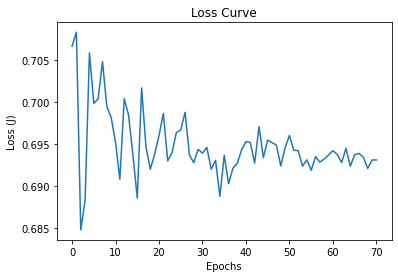

In [19]:
plot_loss_curve(EnhancedNeuralNetwork, X, y, xlabel="Epochs")

In [20]:
hyperparams = {
    "learning_rate": [0.0001, 0.001],
    "tol": [1e-5],
    "max_iter": [1500],
    "alpha": [0.001, 0.0001],
    "hidden_layer_sizes": [(384, 192, 96), (192, 96, 48), (96, 48, 24), (32, 16, 8)]
}

print("CIFAR 10 dataset evaluation:")
evaluate(EnhancedNeuralNetwork, hyperparams, *cifar10)

CIFAR 10 dataset evaluation:
Hyperparameters with optimal F1 score of 0.6189410887397465 (with accuracy of 0.6593333333333333) on the validation set are:
{'alpha': 0.0001, 'hidden_layer_sizes': (192, 96, 48), 'learning_rate': 0.0001, 'max_iter': 1500, 'tol': 1e-05}
Test set F1 score of 0.6116449971735445 and accuracy of 0.6565
Test set classification report:
              precision    recall  f1-score   support

           0       0.63      0.77      0.69      1000
           1       0.70      0.54      0.61      1000

    accuracy                           0.66      2000
   macro avg       0.67      0.66      0.65      2000
weighted avg       0.67      0.66      0.65      2000




__main__.EnhancedNeuralNetwork

# References

* Michael Madden's Lecture Notes for Deep Learning CT5145, National University of Ireland, Galway, 2021.
* Scikit-learn [MLP Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html), [API Reference](https://scikit-learn.org/stable/modules/classes.html) and [Normalizer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Normalizer.html), 2022
* [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html), Learning Multiple Layers of Features from Tiny Images, Alex Krizhevsky, 2009.
* For help with implementations, especially with vectorization, the following two resources were referenced:
    * [Neural Networks & Deep Learning](https://www.coursera.org/learn/neural-networks-deep-learning?specialization=deep-learning) Coursera course by Andrew Ng.
    * Michael A. Nielsen, "[Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/)", Determination Press, 2015



